In [24]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import lightgbm as lgb

import optuna

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')

In [25]:
# Load data
ROOT_DIR = 'mlcourse-dota2-win-prediction'

train_features = pd.read_csv(os.path.join(ROOT_DIR, 'train_features.csv'), index_col='match_id_hash')
train_targets = pd.read_csv(os.path.join(ROOT_DIR, 'train_targets.csv'), index_col='match_id_hash')

# Combine features and targets for EDA
#df = train_features.join(train_targets)
df = train_features.join(train_targets, lsuffix='_features', rsuffix='_targets')


if 'game_time_features' in df.columns:
    game_time_col = 'game_time_features'
elif 'game_time_targets' in df.columns:
    game_time_col = 'game_time_targets'
elif 'game_time' in df.columns:
    game_time_col = 'game_time'
else:
    raise ValueError("No game_time column found in the DataFrame")


# Exploratory Data Analysis (EDA)

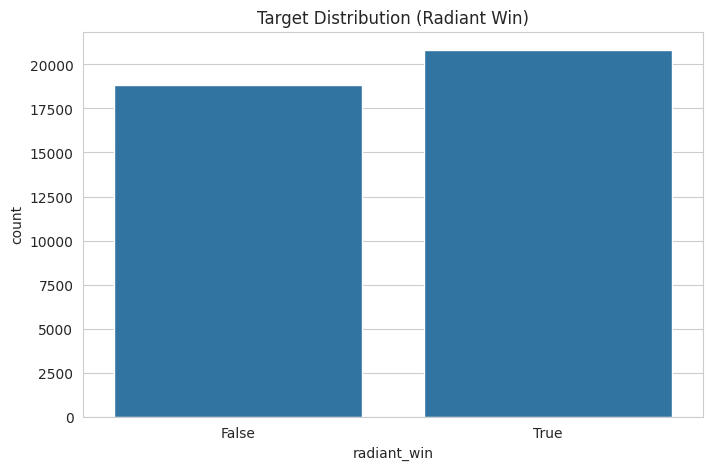

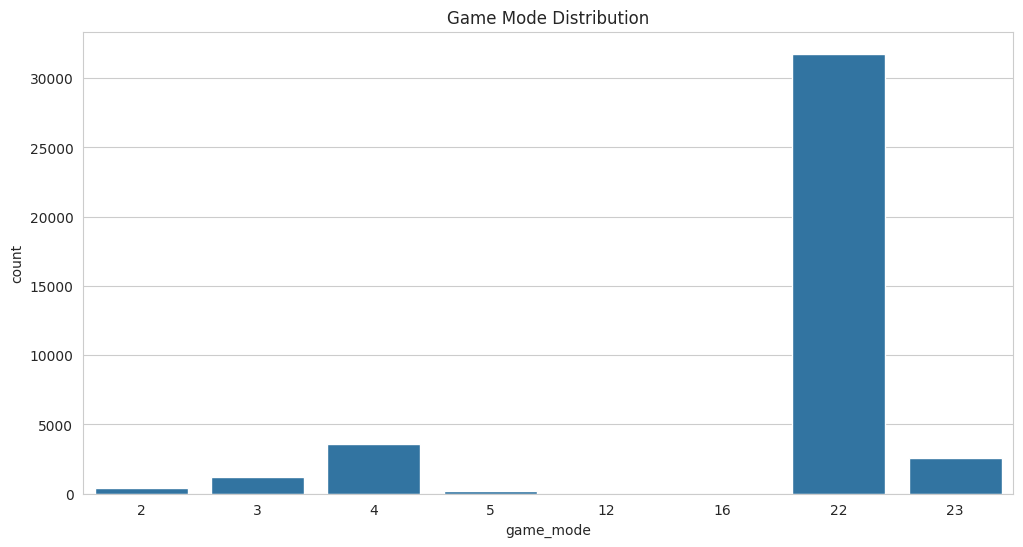

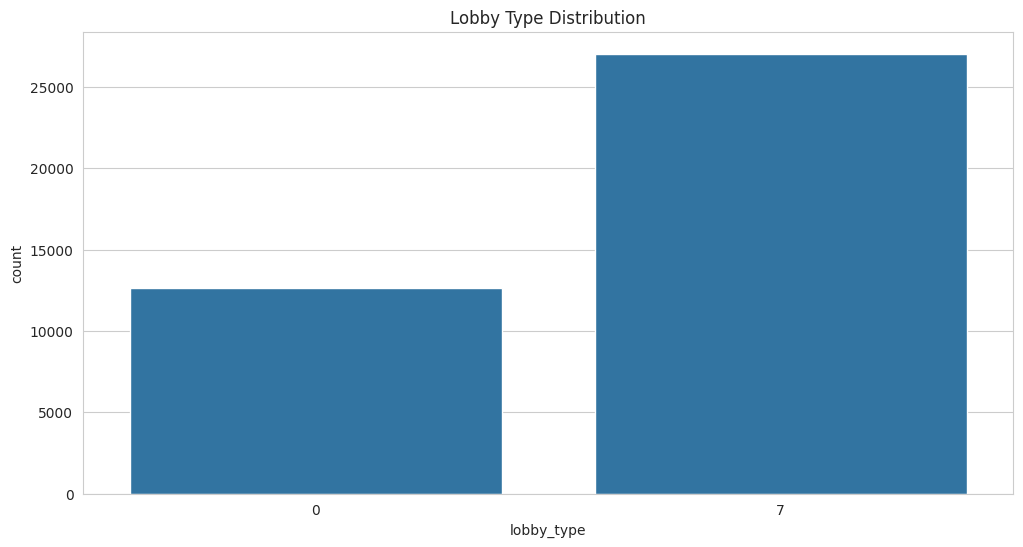

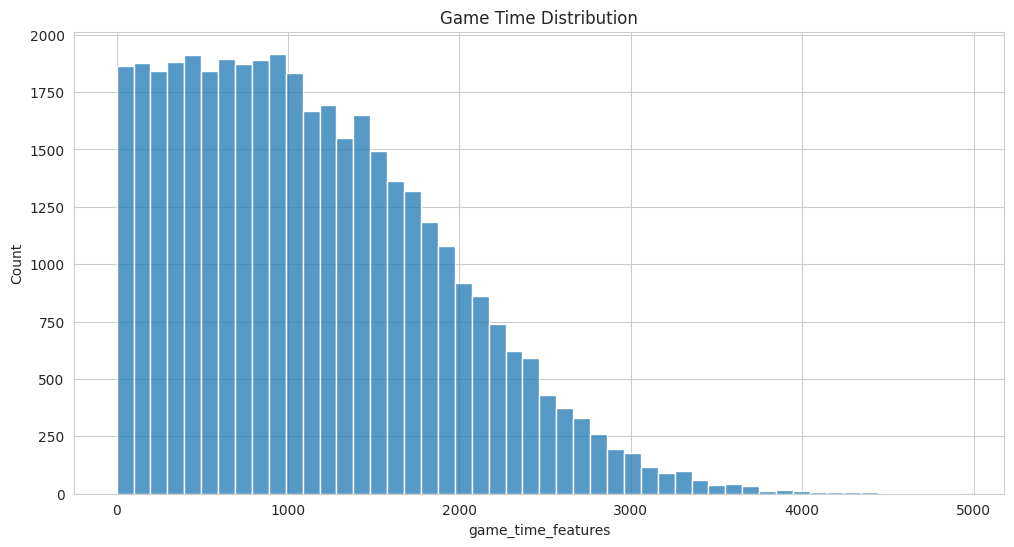

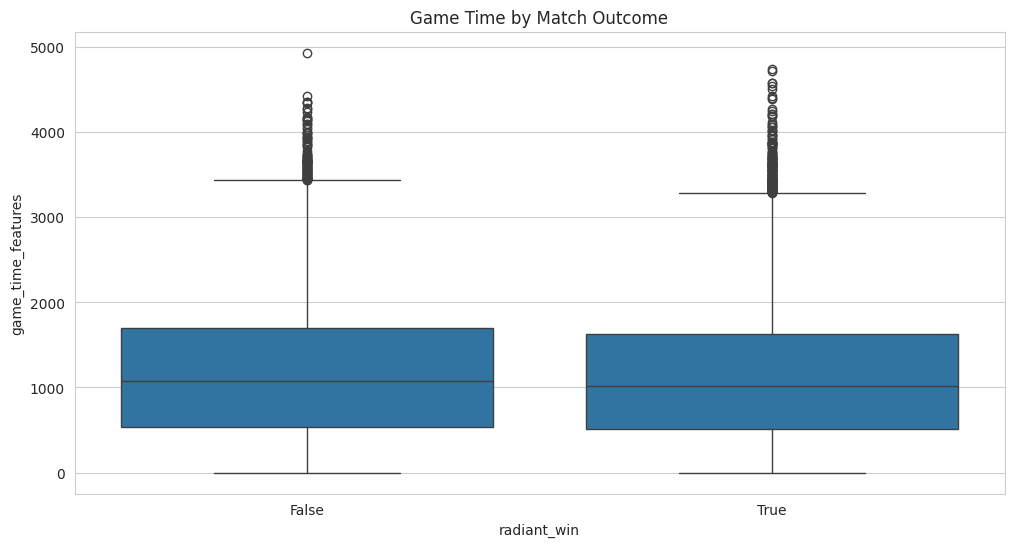

In [26]:
# Target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='radiant_win', data=df)
plt.title('Target Distribution (Radiant Win)')
plt.show()

# Game mode distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='game_mode', data=df)
plt.title('Game Mode Distribution')
plt.show()

# Lobby type distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='lobby_type', data=df)
plt.title('Lobby Type Distribution')
plt.show()

# Game time distribution
plt.figure(figsize=(12, 6))
if 'game_time_features' in df.columns:
    sns.histplot(df['game_time_features'], bins=50)
elif 'game_time_targets' in df.columns:
    sns.histplot(df['game_time_targets'], bins=50)
else:
    print("No game_time column found - available columns:", df.columns.tolist())
plt.title('Game Time Distribution')
plt.show()

# Correlation between game time and radiant win
plt.figure(figsize=(12, 6))
sns.boxplot(x='radiant_win', y=game_time_col, data=df)
plt.title('Game Time by Match Outcome')
plt.show()

# Feature Engineering

In [27]:
def generate_features(data):
    """
    Generate new features from raw data
    """
    # Basic stats for each team
    for c in [
        'kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 
        'health', 'max_health', 'max_mana', 'level', 'x', 'y', 
        'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
        'firstblood_claimed', 'teamfight_participation', 'towers_killed', 
        'roshans_killed', 'obs_placed', 'sen_placed'
    ]:
        radiant_cols = [f'r{i}_{c}' for i in range(1, 6)]
        dire_cols = [f'd{i}_{c}' for i in range(1, 6)]

        eps = 1e-8  # to avoid division by zero
        
        # Team totals
        data[f'radiant_total_{c}'] = data[radiant_cols].sum(axis=1)
        data[f'dire_total_{c}'] = data[dire_cols].sum(axis=1)
        
        # Team ratios
        data[f'total_{c}_ratio'] = data[f'radiant_total_{c}'] / (data[f'dire_total_{c}'] + eps)
        
        # Team averages
        data[f'radiant_avg_{c}'] = data[radiant_cols].mean(axis=1)
        data[f'dire_avg_{c}'] = data[dire_cols].mean(axis=1)
        
        # Team std
        data[f'radiant_std_{c}'] = data[radiant_cols].std(axis=1)
        data[f'dire_std_{c}'] = data[dire_cols].std(axis=1)
    
    # Hero diversity features
    radiant_heroes = [f'r{i}_hero_id' for i in range(1, 6)]
    dire_heroes = [f'd{i}_hero_id' for i in range(1, 6)]
    
    data['radiant_unique_heroes'] = data[radiant_heroes].nunique(axis=1)
    data['dire_unique_heroes'] = data[dire_heroes].nunique(axis=1)
    
    # Game progress features
    data['gold_advantage'] = data['radiant_total_gold'] - data['dire_total_gold']
    data['xp_advantage'] = data['radiant_total_xp'] - data['dire_total_xp']
    
    # Interaction features
    data['kda_ratio'] = (data['radiant_total_kills'] + data['radiant_total_assists']) / (
        data['radiant_total_deaths'] + eps) - (
        data['dire_total_kills'] + data['dire_total_assists']) / (
        data['dire_total_deaths'] + eps)
    
    return data

In [28]:
# Generate features
X = generate_features(train_features)
y = train_targets['radiant_win']

# Identify categorical features
categorical_features = ['game_mode', 'lobby_type']

# Feature Selection

In [29]:
def feature_selection(X, y, categorical_features, n_features=200):
    """
    Select most important features using CatBoost feature importance
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        random_state=42,
        verbose=0,
        cat_features=categorical_features
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=0
    )
    
    # Get feature importance
    feature_importance = model.get_feature_importance()
    feature_names = X.columns
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Select top features
    selected_features = importance_df.head(n_features)['feature'].values
    
    return selected_features

# Select features
selected_features = feature_selection(X, y, categorical_features)

# Model Training

In [40]:
def train_model(X, y, model_class, params, categorical_features=None, n_splits=5):
    """
    Train model with cross-validation
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Handle categorical features
        if categorical_features:
            if model_class.__name__ == 'LGBMClassifier':
                for col in categorical_features:
                    X_train[col] = X_train[col].astype('category')
                    X_valid[col] = X_valid[col].astype('category')
        
        # Initialize model
        model = model_class(**params)
        
        # Fit model
        if model_class.__name__ == 'CatBoostClassifier':
            model.fit(
                X_train, y_train,
                eval_set=(X_valid, y_valid),
                cat_features=categorical_features,
                verbose=0
            )
        elif model_class.__name__ == 'LGBMClassifier':
            model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                categorical_feature=categorical_features
            )
        else:  # XGBClassifier
            model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                verbose=0
            )
        
        # Make predictions
        y_pred = model.predict_proba(X_valid)[:, 1]
        oof_preds[valid_idx] = y_pred
        
        # Print fold results
        fold_auc = roc_auc_score(y_valid, y_pred)
        fold_acc = accuracy_score(y_valid, y_pred > 0.5)
        print(f'Fold {fold + 1}: AUC = {fold_auc:.4f}, Accuracy = {fold_acc:.4f}')
    
    # Print overall results
    oof_auc = roc_auc_score(y, oof_preds)
    oof_acc = accuracy_score(y, oof_preds > 0.5)
    print(f'\nOverall OOF AUC: {oof_auc:.4f}, Accuracy: {oof_acc:.4f}')
    
    return oof_preds

In [ ]:
# CatBoost parameters
cat_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'bagging_temperature': 0.8,
    'border_count': 128,
    'random_state': 42,
    'verbose': 0,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC'
}

# Train CatBoost
available_cat_features = [f for f in categorical_features if f in selected_features]
print("Available categorical features:", available_cat_features)

# Then use only these in training
oof_cat = train_model(
    X[selected_features], y,
    CatBoostClassifier, cat_params,
    available_cat_features  # Use only the ones that exist
)

Available categorical features: []
Fold 1: AUC = 0.8137, Accuracy = 0.7226
Fold 2: AUC = 0.8242, Accuracy = 0.7321
Fold 3: AUC = 0.8203, Accuracy = 0.7325
Fold 4: AUC = 0.8309, Accuracy = 0.7389
Fold 5: AUC = 0.8360, Accuracy = 0.7492

Overall OOF AUC: 0.8249, Accuracy: 0.7350


In [41]:
# LightGBM parameters
lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'binary',
    'metric': 'auc'
}
available_cat_features = [f for f in categorical_features 
                        if f in selected_features and f in X.columns]
print("Доступные категориальные признаки:", available_cat_features)

for feature in available_cat_features:
    X[feature] = X[feature].astype('category')

lgb_params.update({
    'categorical_feature': available_cat_features,
})

oof_lgb = train_model(
    X[selected_features], y,
    lgb.LGBMClassifier, lgb_params,
    available_cat_features,
)

Доступные категориальные признаки: []
[LightGBM] [Info] Number of positive: 16661, number of negative: 15079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36399
[LightGBM] [Info] Number of data points in the train set: 31740, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524921 -> initscore=0.099768
[LightGBM] [Info] Start training from score 0.099768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

KeyboardInterrupt: 

In [42]:
# XGBoost parameters
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'tree_method': 'hist'
}

# Train XGBoost
oof_xgb = train_model(
    X[selected_features], y,
    XGBClassifier, xgb_params
)

KeyboardInterrupt: 

# Blending Models

In [44]:
# Blend predictions
oof_blend = (oof_cat + oof_lgb + oof_xgb) / 3

# Calculate metrics
blend_auc = roc_auc_score(y, oof_blend)
blend_acc = accuracy_score(y, oof_blend > 0.5)

print(f'Blended Model AUC: {blend_auc:.4f}, Accuracy: {blend_acc:.4f}')

NameError: name 'oof_lgb' is not defined

# Feature Importance Analysis

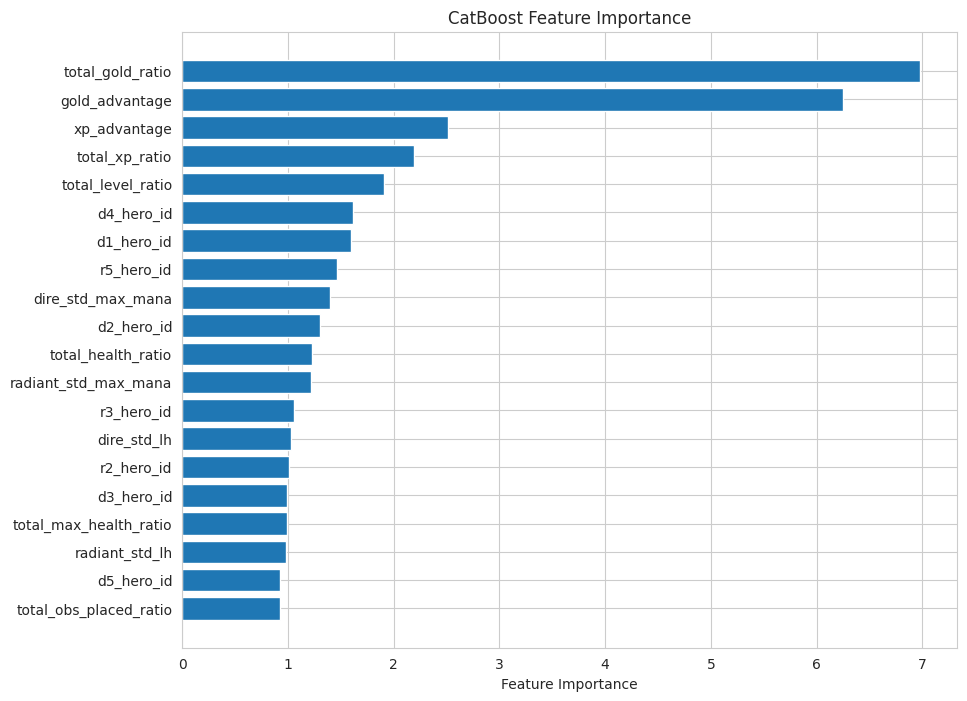

In [46]:
def plot_feature_importance(model, feature_names, title, top_n=20):
    """
    Plot feature importance for a model
    """
    importance = model.feature_importances_
    indices = np.argsort(importance)[-top_n:]
    
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.barh(range(top_n), importance[indices], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.show()

available_cat_features = [feature for feature in categorical_features if feature in X[selected_features].columns]
cat_indices = [X[selected_features].columns.get_loc(feature) for feature in available_cat_features]

# Then train the model
final_cat = CatBoostClassifier(**cat_params)
final_cat.fit(
    X[selected_features], 
    y, 
    cat_features=cat_indices,  # Use indices of categorical features
    verbose=0
)

# Plot feature importance
plot_feature_importance(
    final_cat, 
    X[selected_features].columns, 
    'CatBoost Feature Importance'
)

# Hyperparameter Tuning with Optuna

In [50]:
def optimize_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_state': 42,
        'verbose': 0
    }
    
    # Get available categorical features
    available_cat_features = [f for f in categorical_features if f in X[selected_features].columns]
    cat_indices = [X[selected_features].columns.get_loc(f) for f in available_cat_features]
    
    scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    for train_idx, valid_idx in skf.split(X[selected_features], y):
        X_train, X_valid = X[selected_features].iloc[train_idx], X[selected_features].iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features=cat_indices,  # Use filtered indices
            verbose=0
        )
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        scores.append(roc_auc_score(y_valid, y_pred))
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(optimize_catboost, n_trials=30, timeout=3600)

# Store best parameters
best_cat_params = study.best_params

[I 2025-06-02 16:04:27,829] A new study created in memory with name: no-name-2acaa59c-a28d-4d22-91c8-6b420ab3a992
[I 2025-06-02 16:06:18,060] Trial 0 finished with value: 0.8239901062713467 and parameters: {'iterations': 834, 'learning_rate': 0.03735149194030449, 'depth': 6, 'l2_leaf_reg': 2.138792540090833, 'random_strength': 5.4788775913759755, 'bagging_temperature': 0.013189430924429923, 'border_count': 108}. Best is trial 0 with value: 0.8239901062713467.
[W 2025-06-02 16:08:50,390] Trial 1 failed with parameters: {'iterations': 841, 'learning_rate': 0.012850015935130027, 'depth': 7, 'l2_leaf_reg': 6.769759097007643, 'random_strength': 8.885025838553531, 'bagging_temperature': 0.589617691137256, 'border_count': 213} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/home/sergei/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_81602/13629585

KeyboardInterrupt: 

# Final Model Training with Optimized Parameters

In [53]:
# Train final CatBoost with optimized parameters
final_cat = CatBoostClassifier(**best_cat_params)
final_cat.fit(
    X[selected_features], y,
    cat_features=categorical_features,
    verbose=0
)

# Make final predictions
y_pred = final_cat.predict_proba(X[selected_features])[:, 1]
final_auc = roc_auc_score(y, y_pred)
final_acc = accuracy_score(y, y_pred > 0.5)

print(f'Final Model AUC: {final_auc:.4f}, Accuracy: {final_acc:.4f}')

NameError: name 'best_cat_params' is not defined